In [1]:
# packages
import numpy as np
import pandas as pd
import os

# database
import yfinance as yf
from sqlalchemy import create_engine, inspect

# visualisation
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm



# classifier
from sklearn.svm import SVC

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split,
                                    TimeSeriesSplit,
                                    GridSearchCV,
                                    RandomizedSearchCV
                                    )

# metrics
from sklearn.metrics import (
                            accuracy_score,
                            classification_report,
                            RocCurveDisplay,
                            ConfusionMatrixDisplay,
                            log_loss,
                            mean_squared_error)

/Users/jackstevenson/CQF/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


1. What is the cost function of Logistic Regression? Explain in Detail


2. What are voting classifiers in ensemble learning?

3. Support Vector Machine model to predict short term returns S&P 500. 


### 3.1 Data Collection & Preprocessing 

We will use the yfinance python package to pull data on the S&P 500 Index (SPX) via an API from Yahoo Finance. The data has already been cleaned and does not contain missing or stale values on weekends or market holidays. 



In [4]:
# This pulls end of data data - we need minimum 5 years
# df = yf.download('^SPX', start='2000-01-01')

# create our engine
engine = create_engine("sqlite:///spx500.db")

# if_exits will overwrite the pre-existing table
# df.to_sql('spx500', engine, if_exists=True, index=True, index_label='Date')

# read the table
df = pd.read_sql_query('SELECT * FROM  "spx500"', engine, index_col='Date')

# converts the data index to datatime format
df.index = pd.to_datetime(df.index)

### 3.2 Feature Engineering

Features or Predictors are the independent variables which are used to determine the value of the target variable. We will derive a features set from the dataset pulled from yahoo finance. 

In [6]:
# create features
df['DAILY_RET'] = df['Close'].pct_change()

# O-C, HL
df["HIGH_LOW"] = df['High'] - df['Low']
df['OPEN_CLOSE'] = df['Open'] - df['Close']

# Sign
df['SIGN_RET'] = np.sign(np.log(df['Close'] / df['Close'].shift(1)))

# Past Returns
df['LAG_1_CLOSE'] = df['DAILY_RET'].shift(1)

# Momentum
df['MOMENTUM'] = df['Close'] - df['Close'].shift(3)

# Moving Average
df['MOVE_AVG'] = df['DAILY_RET'].rolling(3).mean()

# Exponential Moving Average
# Smoothing factor is α = 2/(N_obs + 1)
N = 3
alpha = 2 / (N + 1)
df['EXP_MOVE_AVG'] = df['DAILY_RET'].ewm(alpha=alpha, adjust=False).mean()

# volume
df['DAILY_VOLUME'] = df['Volume'].pct_change()

# drop the nan values
df.dropna(inplace=True)

# remove the unnecessary columns 
unnecessary_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'DAILY_RET']
features = df.drop(unnecessary_columns, axis=1)

# strip out the columns and index
X = features.values

#### Target Variable

The target variable is the variable or metric tht you are trying to predict with a supervised machine learning model. The target variable in our model will be whether the index price moves up or down. To guard against the excessive volatility of our index we want to ensure that 'buy' signals are robust and therefore we will introduce a minimum threshold that must be cleared to deal with very small price movements. We will firstly take the long term average daily return and only categorise a positive index move as a 'buy' when the price movement is greater than that long term average move. We will assign a value of 1 for buy and 0 otherwise. This also gives the added benefit of a fairly equal number of classifications on both sides. 
 

In [9]:
long_term_mean = df['DAILY_RET'].mean()

y = np.where(df['DAILY_RET'].shift(-1) > long_term_mean, 1, 0)

pd.Series(y).value_counts()

print(f'The number of upward price moves over the threshold is {pd.Series(y).value_counts()[1]}, and the number that failed to meet this criteria is {pd.Series(y).value_counts()[0]}')

The number of upward price moves over the threshold is 3168, and the number that failed to meet this criteria is 2962


### 3.3 Support Vector Machines - Base Model

Support Vechtor Machines are commonly used with classification models. They distinguish between two different classes by establishing a hyperplane between them with the proviso that the correct hyperplane is the one with the maximum amount of space between the line and the classes. The distance between the hyperplane and the classes is known as the margin and the cases that define the margin are called the support vectors. 

In the event that the data is not linearly separable then we have to introduce non-linear support vector machines accessed. In order to make the data linearly separable, preprocessing methods are applied to the data to transform it into higher-dimensional space to increase the number of hyperplanes that can be drawn to separate the data. There are a number of kernels types accessible via sklearn package that can achieve this for us; they include the radial basis function (RBF), polynomial and sigmoid kernels. 

We will now initialise our model and evaluate our data. 

Overfitting is when data is trained to 'perfection' on training data and ultimately only regurgitates information about the training data rather than applying general principles from the data to predict information about new sources of data. As a result it is common to hold back a portion of the data from training so that the model can be evaluated. The most common split is an 80:20 split between the 'training' set and 'test' set respectively. 

In [59]:
# split the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# default kernel is rbf
classifier = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC())   
])

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# get the Scores
acc_train = accuracy_score(y_train, classifier.predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train}, Test Accuracy: {acc_test}')

Baseline Model -- Train Accuracy: 0.5642332789559543, Test Accuracy: 0.5040783034257749


### 3.4 Model Evaluation - ROC, Confusion Matrix and Classification Report

The confusion matrix allows us to visualise the performance of our classification algortihm. Each row of the matrix represents the actual labels of the target variable, and the columns display the predicted labels of the target variable. This allows us to neatly see the true positives / negatives alongside the false positives / negatives. 

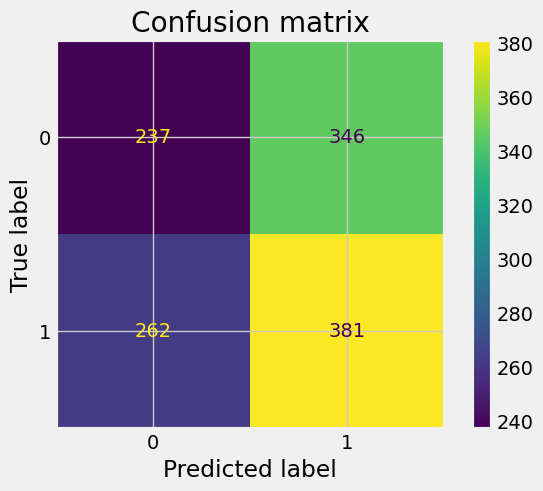

In [24]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
X_test,
y_test,
# display_labels=model.classes_, cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

The performance of our algorithm is initially very poor. The algorithm is unable to correctly predict up and down movements of our index, this leads to almost equal number of true positives / negatives and false positives / negatives. This is indistinguishable from random selection. 

### Receiver Operator Characterisitc (ROC) Curve 

ROC curves feature the true positive rate on the Y-axis, and the false positive rate on the X-axis. The true positive rate represents the proportion of actual positive instances that were correct classified as positive by the model. 

$$
TPR = \frac{TP}{TP + FN}
$$

Where $TP$ is true positive, and $FN$ is false positive.

Equally the false positive rate gives the proportion of all negatives incorrectly classified as positive. 

$$
FPR = \frac{FP}{TN + FP}
$$

Where $FP$ is false positive, and $TN$ is true negative. 

The 'ideal' point on the graph is the top left hand corner where the true positives rate is equal to 1 and false positive rate is 0. The aim is to ensure our algorithm performs as close to the 'ideal' as possible, and therefore the greater the area under the curve tends to represent a better performance by our classification model. 

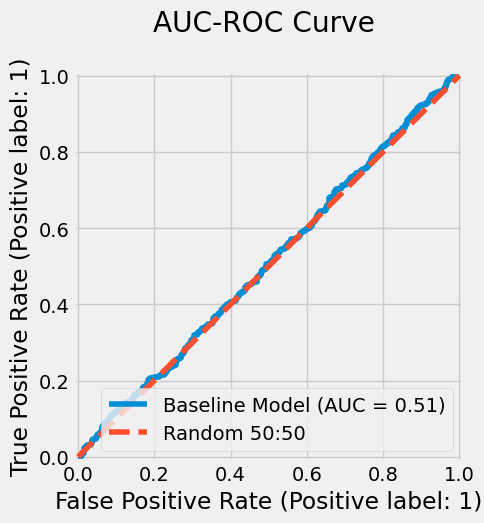

In [22]:
# display ROCCurve
disp = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The ROC curve confirms the poor performance observed in the confusion matrix, indicating that the model's predictions are not significantly better than random selection.

#### Classification Report

The classification report three different metrics to measure the performance of our algorithm and displays it in a simple table. The metrics are precision, recall and F1 Score. Precision measures the number of correct predictions relative to the total number of predictions for that classification. Recall is the percentage of correct predictions relative to actual values for that classification. The F1 score is a weighted harmonic mean of precision and recall. 

In [26]:
# classification Report
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.41      0.44       583
           1       0.52      0.59      0.56       643

    accuracy                           0.50      1226
   macro avg       0.50      0.50      0.50      1226
weighted avg       0.50      0.50      0.50      1226



As we have seen from the evaluation the model is currently performing poorly. We will know undertake three methods to try and improve the overall performance of the algorithm. They will be as follows Cross Validation, Hyper-Parameter Tuning and Feature Selection. 

### 3.4 Cross Validation

When evaluating different setting ('hyperparameters') for estimation, such as $c$ setting that must be manually set for SVM, there is a risk of overfitting because the parameter can be tweaked until the estimate performs optimally on the training data. Knowledge about the test set can 'leak' into the model and evaluation no long reports on general performance. To overcome this issue an additional set of data is held back from the training and test sets to form a validation set. 

The order of operation then becomes as follows; the 'training' data is use to build the model, the evaluation is then performed on the 'validation set', and then final performance is measured by accuracy on the 'test' set. 

The requirement to partition out data into three separate sets leads to a sizeable reduction in the number of samples available for training the model. Cross-Validation is partial solution to this problem. We still require data to be held back for the 'test' set but we no long require a validation set. 

The basic approach, known as the k-fold cross-validation, divides the training set is equal sized $k$ sets. The following procedure is then applied: 

- Select one of the $k$ groups to function as the test set
- The remaining groups are used as the training data. 
- Fit the model and evaluate based on the chosen test set. 
- Retain the evaluation score and then discard the model. 

You then take the average of the values computated as the k-fold cross-validation score. This is the most efficient use of the data, but it is also computationally expensive. Usually the choice of $k$ is between 5 to 10. 

#### Cross-validation of time series data

Time series data is characterised by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation technqiues assume that the samples are independent and identically distribution. As a result if the time series data is divided randomly information about the future can 'leak' from training data into the test set due to this unresonable correlation between instances. We need to ensure when performing our cross-validation that the temporal structure of the time series data is maintained. The TimeSeriesSplit method in sklearn achieves this by ensuring that the structure is mantained and the latest data available is used as the testing set and the training data only contains data prior to the start of the test set. 

In [51]:
# number of folds
n_splits = 10

tscv = TimeSeriesSplit(n_splits = n_splits)

In [52]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

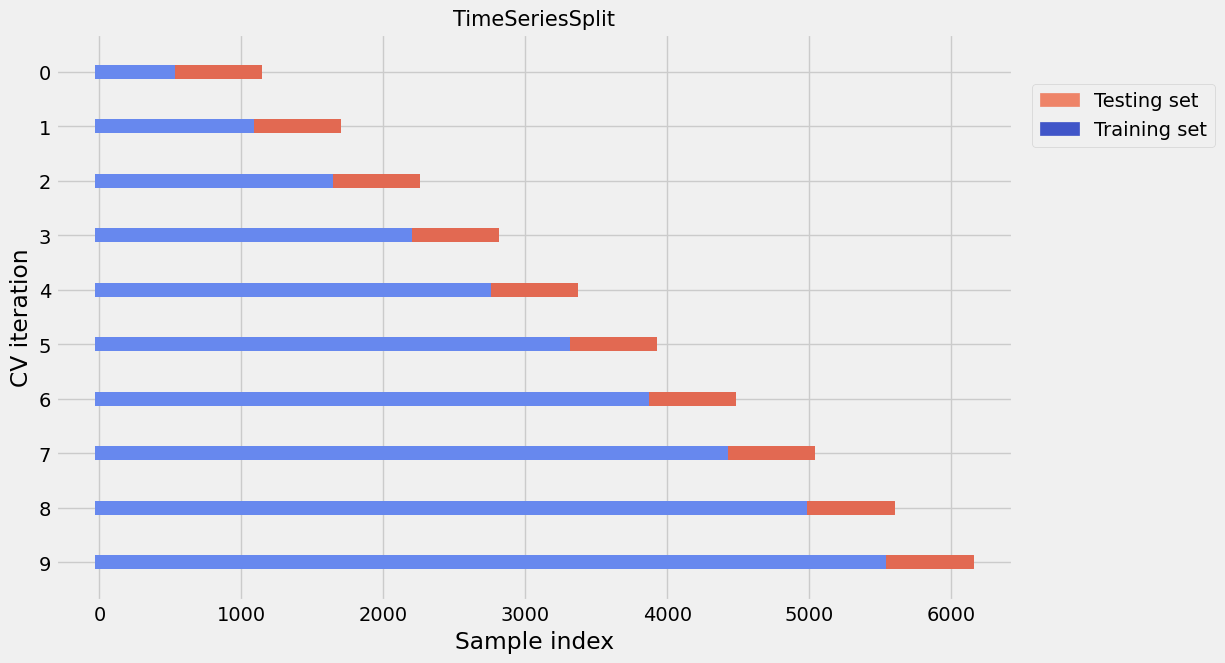

In [53]:
# Plotting TimeSeriesSplit with CV
plot_cv_indices(tscv, n_splits, X, y, date_col=None)

### 3.5 Hyper-Parameter Tuning

Now that we have a cross-validation that successfully maintains the temporal structure of our data we can begin to evaluate our hyper-parameters. Hyper-parameters are parameters that are not directly learnt within estimators. They are external configuration variables that are controlled to manage the model training process. There are no set rules on which hyperparameter value is optimal, the values need to be tuned with the specific model. They are passed as arguments to the constructor of the estimator class in sklearn. 

There are three specific hyper parameters within the SVM model. 

We have the regularisiation parameter (C) which controls the largest minimum margin on our hyper plane. The SVM model is attempting to draw a hyperplane that separates our two different classifications as optimally as possible. The margin refers to the maximum width of the boundary that we can draw between the classes. The smaller the value of this margin, the more SVM attempts to minimise the training error and attempts to ensure there are minimal classification errors. The main risk is that a smaller margin leads to overfitting the data, while a larger margin can provide a more generalised hyperplane at the risk of leading to more classificatione errors. The parameter $c$ is known as the regularisation parameter and controls the the largest minimum margin in our classifier. The parameter $c$ is inversely proportional to the margin size, a smaller value of $c$ leads to a larger margin, and vice-a-versa. 

The gamma parameter defines how far the influence of a single training example reaches, similar to $c$ the value of gamma is inversely proportional to the training points influence. Low values indicates a large similarity radius and leads to a smoother and more generalised decision boundary. The model is less sensitive to indivudal data points which can prevent overfitting but equally if not tuned correctly it may not accurately map the complexity of the data. A high value of gamma means that the influence of a single training point is limited to a small area. This creates a tightly fitted and more complex decision boundary/. The model is able to capture more intricate patterns within the data, but is more susceptible to overfitting the training data rather than generalising the relationship.

The final hyper parameter is our choice of kernel. There are four choices for the kernel (excluding custom kernels); linear, radial basis function (RBF), polynomial and sigmoid. The linear kernel is the most computationally efficient and does not require the gamma parameter, but is limited to linearly separable data and cannot accurately capture complex relationships from non-linear data. The polynomial is used when the data has a complicated curved border, however it is prone to overfitting and requires careful parameter tuning. The RBF kernel is applied when the data has no clear boundaries and complicated areas of overlap, like the polynomial it can be prone to overfiting. The sigmoid kernel is more limited and tends to perform best with specific circumstances. 

Note to Examiner: I will tune each of the hyper-parameters separately for clarity and due the time-cost of tuning together. 

We will be utilising the GridSearchCV cross-validation methodology in combination with TimeSereisSplit to tune our hyper parameters. 

In [54]:
# Kernel Choice
# Define the parameter grid

param_grid = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# # initialise GridSearchCV with our TimeSeriesSplit class from earlier
grid_search = GridSearchCV(classifier, param_grid, cv=tscv, scoring="accuracy")

grid_search.fit(X, y)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Extract results and create a DataFrame
results = grid_search.cv_results_
df_results = pd.DataFrame(results)

# # Select and rename relevant columns for better readability
df_results = df_results[['param_classifier__kernel', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_results.columns = ['Kernel Choice', 'Mean Test Score', 'Std Test Score', 'Rank']

df_results.sort_values('Rank', ascending=True)

,Kernel Choice,Mean Test Score,Std Test Score,Rank
0,linear,0.526930,0.026873,1
2,rbf,0.520287,0.027566,2
1,poly,0.514363,0.021963,3
3,sigmoid,0.502873,0.028038,4


We can see from the table above that the linear kernel performed best. The linear kernel is only able to capture linearly separable data, and we could expect the relationship between our defined features and the S&P500 is not strictly linear. We will use the RBF kernel which performs slightly worse in the initial tuning but should have a great capacity for modelling the relationship we would expect. 

The GridSearchCV can be used for numeric data but we can also use the RandomizedGridSearch to define a range of values that we would consider reasonable and then allow the algorithm to try any random combination of those variables and evaluate the output. 

In [56]:
from scipy.stats import uniform

# randomised GridSearchCV

# Define the parameter distribution
param_dist = {
    'classifier__kernel': ['rbf'],
    'classifier__C': uniform(0.1, 100),  # Uniform distribution between 0.1 and 100
    'classifier__gamma': uniform(0.001, 1)  # Uniform distribution between 0.001 and 1
}

# Set up RandomizedSearchCV with TimeSeriesSplit
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=50, cv=tscv, scoring='accuracy', random_state=42)

# Fit the model
random_search.fit(X, y)

# Extract results and create a DataFrame
results = random_search.cv_results_
df_results = pd.DataFrame(results)

# Select and rename relevant columns for better readability
df_results = df_results[['param_classifier__C', 'param_classifier__gamma', 'mean_test_score', 'std_test_score', 'rank_test_score']]
df_results.columns = ['C', 'Gamma', 'Mean Test Score', 'Std Test Score', 'Rank']

df_results.sort_values('Rank', ascending=True).head()

,C,Gamma,Mean Test Score,Std Test Score,Rank
2,15.701864,0.156995,0.519749,0.022109,1
36,0.652212,0.816461,0.519390,0.029204,2
49,2.641913,0.108891,0.519031,0.022602,3
39,35.946573,0.116869,0.516697,0.020451,4
7,18.282497,0.184405,0.516158,0.015491,5


### 3.6 Feature Selection 


### 3.8 Support Vector Machine - Tuned Model Evalution

Now we have successfully tuned the hyperparameters and evaluated our features we can re-initialise our model and evaluate performance. 

In [60]:
classifier = Pipeline([
        ("scaler", StandardScaler()),
        ("classifier", SVC(kernel='rbf', C=15.701864, gamma=0.156995))   
])

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

# get the Scores
acc_train = accuracy_score(y_train, classifier.predict(X_train))
acc_test = accuracy_score(y_test, classifier.predict(X_test))
print(f'Baseline Model -- Train Accuracy: {acc_train}, Test Accuracy: {acc_test}')

Baseline Model -- Train Accuracy: 0.6300978792822186, Test Accuracy: 0.5130505709624796


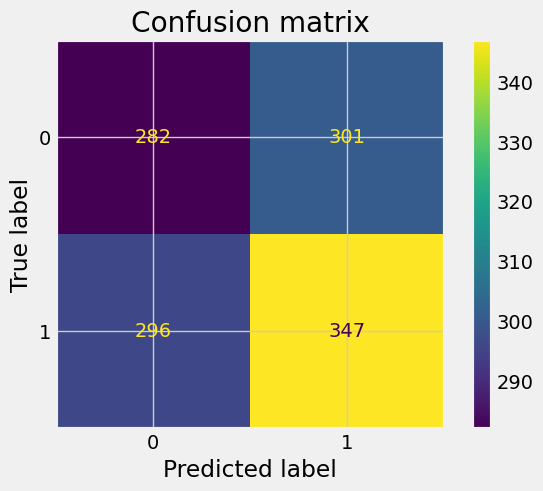

In [61]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
X_test,
y_test,
# display_labels=model.classes_, cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

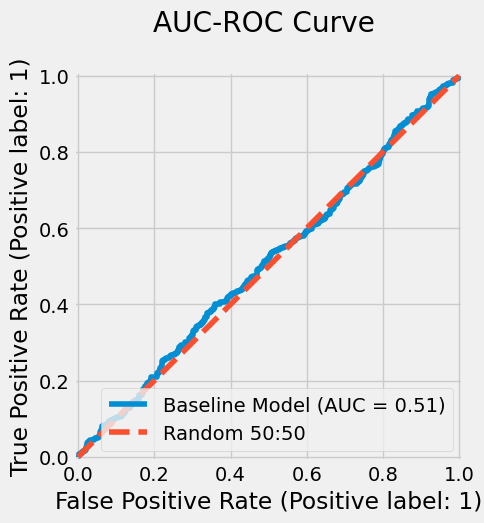

In [62]:
# display ROCCurve
disp = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name='Baseline Model')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

In [63]:
# classification Report
print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.48      0.49       583
           1       0.54      0.54      0.54       643

    accuracy                           0.51      1226
   macro avg       0.51      0.51      0.51      1226
weighted avg       0.51      0.51      0.51      1226



### 3.9 Conclusion